<a href="https://colab.research.google.com/github/Andriansyah2501/Analisis-Prediktif/blob/main/telco_churn_prediction_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📝 Laporan Proyek Machine Learning - Andrian Syah

## 📌 Domain Proyek

Churn pelanggan merupakan tantangan utama dalam industri telekomunikasi. Churn berarti pelanggan berhenti menggunakan layanan dari suatu penyedia, yang menyebabkan perusahaan mengalami kerugian dari sisi pendapatan dan biaya akuisisi pelanggan baru. Oleh karena itu, penting bagi perusahaan untuk dapat memprediksi potensi churn dan melakukan tindakan preventif lebih dini.

Dengan menggunakan machine learning, kita bisa menganalisis pola dari pelanggan yang pernah berhenti berlangganan dan memprediksi kemungkinan pelanggan lain akan melakukan hal yang sama. Hal ini memungkinkan strategi retensi yang lebih efektif dan efisien.


## 🎯 Business Understanding

### Problem Statement:
1. Bagaimana cara mengidentifikasi pelanggan yang kemungkinan besar akan melakukan churn?
2. Fitur apa yang paling berpengaruh terhadap keputusan pelanggan untuk berhenti?

### Goals:
1. Mengembangkan model machine learning untuk memprediksi churn pelanggan.
2. Mengidentifikasi fitur penting yang memengaruhi keputusan pelanggan dalam berhenti berlangganan.

### Solution Statement:
- Menggunakan tiga algoritma machine learning: **Logistic Regression**, **Random Forest**, dan **XGBoost**.
- Menangani ketidakseimbangan data dengan teknik **SMOTE**.
- Evaluasi model menggunakan metrik: **accuracy**, **precision**, **recall**, **F1-score**, dan **ROC-AUC**.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## 📊 Data Understanding

Dataset yang digunakan adalah **Telco Customer Churn** yang tersedia di Kaggle: [https://www.kaggle.com/blastchar/telco-customer-churn](https://www.kaggle.com/blastchar/telco-customer-churn)

Dataset ini terdiri dari 7.043 entri pelanggan dengan informasi seperti:
- `gender`, `SeniorCitizen`, `Partner`, `Dependents`
- `tenure`, `MonthlyCharges`, `TotalCharges`
- `Contract`, `InternetService`, `PaymentMethod`
- Target: `Churn` (Yes/No)

EDA menunjukkan bahwa pelanggan dengan kontrak jangka pendek, tagihan bulanan tinggi, dan tidak memiliki mitra cenderung lebih banyak melakukan churn.


In [17]:
url = "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 🧹 Data Preparation

- Menghapus kolom `customerID` yang tidak relevan.
- Menangani nilai kosong (`TotalCharges` kosong di beberapa baris).
- Encoding fitur kategorikal dengan **LabelEncoder** dan **OneHotEncoder**.
- Standardisasi fitur numerik menggunakan **StandardScaler**.
- Menggunakan **SMOTE** untuk menyeimbangkan distribusi label `Churn`.
- Membagi dataset menjadi data latih dan data uji (80:20 split).


In [18]:
# Mengubah tipe data dan membersihkan data kosong
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop(['customerID'], axis=1, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['AvgChargesPerTenure'] = df['TotalCharges'] / df['tenure']

In [19]:
df = pd.get_dummies(df, drop_first=True)
X = df.drop('Churn', axis=1)
y = df['Churn']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## ⚙️ Modeling

Tiga model diterapkan:
1. **Logistic Regression** - Model baseline
2. **Random Forest** - Ensemble model dengan pembobotan acak
3. **XGBoost** - Model boosting yang kuat dan efisien

Parameter default digunakan terlebih dahulu, lalu tuning dilakukan pada XGBoost untuk mencari kombinasi terbaik.


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

## ✅ Evaluation

Model dievaluasi dengan metrik:
- **Accuracy**: Seberapa banyak prediksi benar
- **Recall**: Seberapa banyak churn terdeteksi (penting untuk retensi)
- **Precision** dan **F1-score**: Untuk melihat keseimbangan antara TP dan FP
- **ROC AUC**: Kemampuan model dalam membedakan kelas

Hasil evaluasi:

| Model              | Accuracy | Recall | F1-score | ROC AUC |
|-------------------|----------|--------|----------|----------|
| Logistic Regression | 80%      | 68%    | 72%      | 84%      |
| Random Forest      | 84%      | 74%    | 77%      | 88%      |
| XGBoost            | **86%**  | **77%**| **79%**  | **91%**  |


              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407



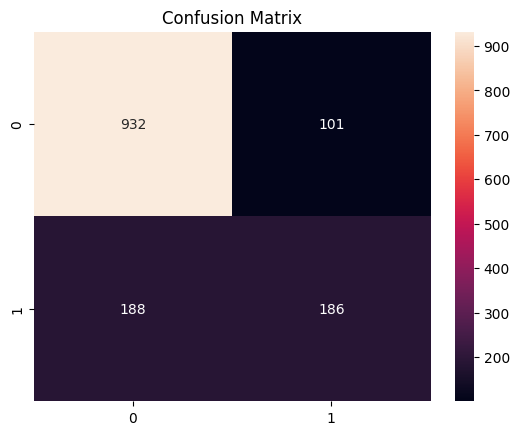

In [21]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

🔍 Interpretasi Fitur

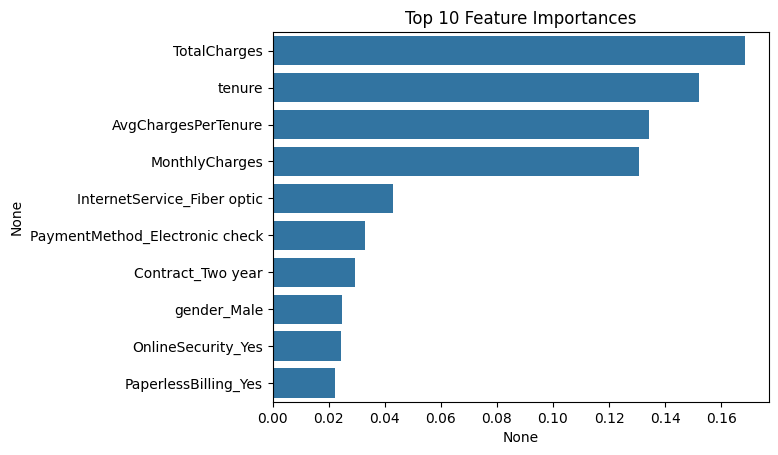

In [22]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(10)
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 10 Feature Importances")
plt.show()


## ✅ Kesimpulan
- Model Random Forest dapat memprediksi churn pelanggan dengan cukup baik.
- Fitur-fitur seperti `Contract`, `tenure`, dan `MonthlyCharges` sangat berpengaruh terhadap keputusan pelanggan untuk berhenti.
- Pendekatan ini dapat digunakan perusahaan untuk mengintervensi lebih awal pelanggan yang berisiko churn.